In [1]:
import gc
import glob
import os
import random
import re
import tarfile

import flash
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import sklearn
import torch
import torchvision
from PIL import Image
from sklearn.datasets import fetch_openml
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, tp_name):


In [2]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


SEED = 2913
fix_seed(SEED)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# GANによる画像生成(DCGAN)

本ノートブックでは、DCGANの実装を行なっていく。Self-Attention GANは別のNotebookにて実装する。

なお、書籍ではMNISTの"7"と"8"の手書きデータのみを学習させているが、せっかくなので全ての文字を学習させてみる。

DCGANの目標は、ある数を入力とした時、手書きっぽい数字の画像を作成すること。この入力とする数を様々に変更することにより、多種多様な出力画像、すなわち手書きの数字の画像を作成できるようになる。

これを実現するため、GANはGenerator(画像生成部)とDiscriminator(画像判別部)を構成する。

細かな実装は以降で説明する。

## データの確認及びDataset, DataLoaderの作成

MNISTは手書きの1桁の数字を扱ったデータ。

ありがたいことにtorchvisionにMNISTがあるので、それを使うことにする。ただし、torchvisionのデータセットは学習用データと検証用データに分かれている。学習フェーズのコードを見れば分かるように、本学習では検証用データは不要なので、train_datasetとval_datasetの両方を学習データとする。PyTorchのデータセットクラスはうまくできていて、2つのデータセットの結合は単純にプラスで演算をしてあげるだけで可能。

MNISTの画像サイズは28x28だが、書籍に合わせて64x64に拡大する。~~これをtransformでやってもいいのかもしれないが、極めて遅くなるので、ミニバッチでの入力前に`torch.nn.functional.interpolate`で拡大することにする。~~->そんなに変わらなかった。

~~また、ランダムノイズも加えておくことにする。~~

In [4]:
class MnistTransform:
    def __init__(
        self,
    ):
        self.transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize((64, 64)),
                # torchvision.transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
                torchvision.transforms.ToTensor(),
            ]
        )

    def __call__(self, x):
        return self.transform(x)

In [5]:
transform = MnistTransform()
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, target_transform=None, download=True
)
val_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    target_transform=None,
    download=True,
)
dataset = train_dataset + val_dataset

In [6]:
display(train_dataset)
print("train_dataset shape:", train_dataset.data.shape)
display(val_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: <__main__.MnistTransform object at 0x7ff9f018b910>

train_dataset shape: torch.Size([60000, 28, 28])


Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: <__main__.MnistTransform object at 0x7ff9f018b910>

Text(0.5, 0.98, 'MNIST Dataset')

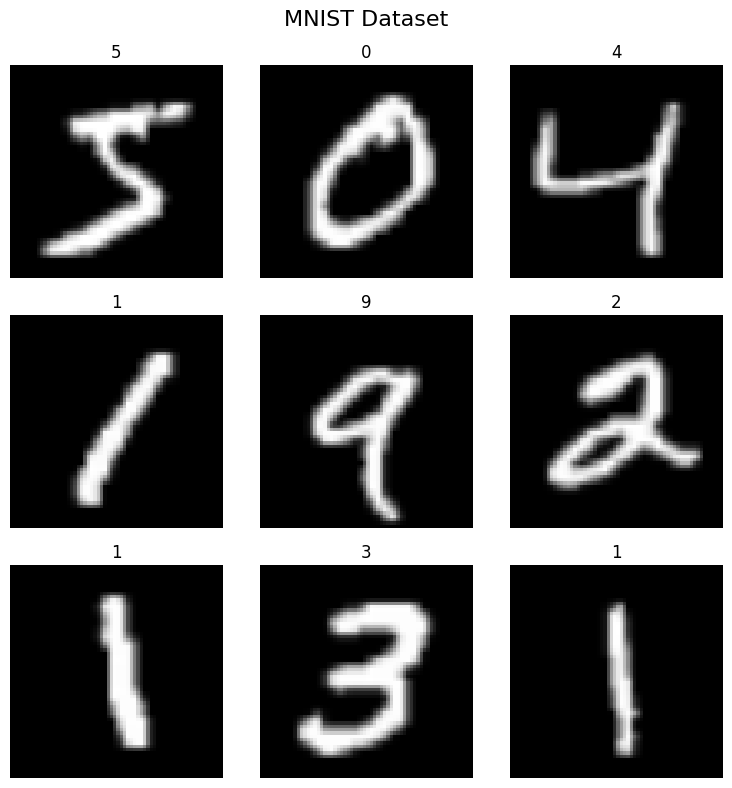

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_dataset[i][0].squeeze(), cmap="gray")
    ax.set_title(train_dataset[i][1])
    ax.set_axis_off()
fig.set_tight_layout(True)
fig.suptitle("MNIST Dataset", fontsize=16)

データの平均と標準偏差を確認。

データは概ね真ん中に密集していることがわかる。そのため、特別な前処理は不要。

Text(0.5, 0.98, 'MNIST Dataset')

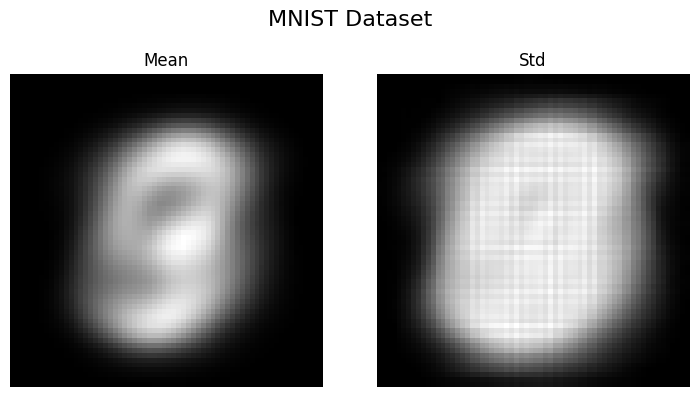

In [8]:
# add all in train_dataset and show heatmap
train_data = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])
train_mean = torch.mean(train_data, dim=0)
train_std = torch.std(train_data, dim=0)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(train_mean.squeeze(), cmap="gray")
axes[0].set_title("Mean")
axes[0].set_axis_off()
axes[1].imshow(train_std.squeeze(), cmap="gray")
axes[1].set_title("Std")
axes[1].set_axis_off()
fig.set_tight_layout(True)
fig.suptitle("MNIST Dataset", fontsize=16)

In [9]:
batch_size = 2048
train_data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
    persistent_workers=True,
)

## Genaratorの実装

Generatorは、ある数字から64x64の手書きの数字画像を作成する。つまり、(in_channels, 1, 1)のサイズのテンソルから(1, 64, 64)のサイズのテンソルを作成することになる。

書籍では、すべての実装をGeneratorクラスに書いているが、step-by-stepで動作を確認するため、まずはDeconv2dクラスを作成して実装を確認していく。以下、バッチサイズ(次元0)は省略。

```mermaid:Generator
flowchart LR;
    input( )
    output( )
    d1(Deconv2d)
    d2(Deconv2d)
    d3(Deconv2d)
    d4(Deconv2d)
    d5(Deconv2d)
    input--(in_channels,1,1)-->d1
    subgraph Generator
        d1--(512,4,4)-->d2--(256,8,8)-->d3--(128,16,16)-->d4--(64,32,32)-->d5
    end
    d5--(1,64,64)-->output
```

なお、`ConvTranspose2d`の入出力の次元は[公式ドキュメント](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)から頑張って計算する。

In [10]:
class Deconv2d(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels, with_batch_norm=True, **kwargs):
        super().__init__()
        self.add_module(
            "ConvTranspose2d",
            torch.nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
        )
        if with_batch_norm:
            self.add_module("BatchNorm2d", torch.nn.BatchNorm2d(out_channels))
        self.add_module("ReLU", torch.nn.ReLU(inplace=True))

In [11]:
_batch_size = 4
_in_channels = 20
_inputs = torch.randn(_batch_size, _in_channels, 1, 1)
_outputs = Deconv2d(_in_channels, 512, kernel_size=4, stride=1)(_inputs)
assert _outputs.shape == (_batch_size, 512, 4, 4)
del _batch_size, _in_channels, _inputs, _outputs

In [12]:
_batch_size = 4
_inputs = torch.randn(_batch_size, 512, 4, 4).to(device)
_model = Deconv2d(512, 256, kernel_size=4, stride=2, padding=1).to(device)
_outputs = _model(_inputs)
assert _outputs.shape == (_batch_size, 256, 8, 8)
del _batch_size, _inputs, _outputs
torch.cuda.empty_cache()

In [13]:
class Generator(torch.nn.Sequential):
    def __init__(self, in_channels):
        super().__init__(
            Deconv2d(in_channels, 512, kernel_size=4, stride=1),
            Deconv2d(512, 256, kernel_size=4, stride=2, padding=1),
            Deconv2d(256, 128, kernel_size=4, stride=2, padding=1),
            Deconv2d(128, 64, kernel_size=4, stride=2, padding=1),
            Deconv2d(64, 1, kernel_size=4, stride=2, padding=1, with_batch_norm=False),
        )

未学習のモデルでは、ランダムな画像が生成されることを確認する。

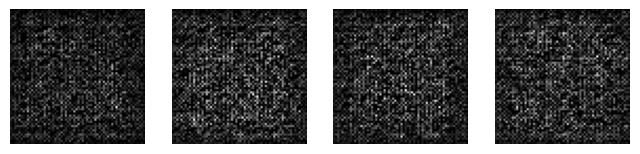

In [14]:
_batch_size = 4
_in_channels = 20
_inputs = torch.randn(_batch_size, _in_channels, 1, 1)
_outputs = Generator(_in_channels)(_inputs)
fig, axes = plt.subplots(1, _batch_size, figsize=(8, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(_outputs[i].squeeze().detach().numpy(), cmap="gray")
    ax.set_axis_off()
plt.show()
assert _outputs.shape == (_batch_size, 1, 64, 64)
del _batch_size, _in_channels, _inputs, _outputs

## Discriminatorの実装

Discriminatorは、Generatorの生成した画像が手書きかどうかを判定すれば良い。実現したい動作は普通のニューラルネットワークと同じなので、単純な実装で良いが、後述のGeneratorのバックプロパゲーションを考慮して活性化函数にはLeakyReLUを使用する。

In [15]:
class Discriminator(torch.nn.Sequential):
    def __init__(self):
        super().__init__(
            torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            torch.nn.LeakyReLU(0.1, inplace=True),
            torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        # convert (batch_size, 1, 1, 1) to (batch_size)
        return super().forward(x).view(-1)

In [16]:
_batch_size = 4
_inputs = torch.randn(_batch_size, 1, 64, 64)
_outputs = Discriminator()(_inputs)
assert _outputs.shape == (_batch_size,)
del _batch_size, _inputs, _outputs

## 学習

DiscriminarorをD, GeneratorをGと表すとする。
この時、$G(x)$は生成された画像のテンソルを示し、$D(G(x))$は生成された画像が手書き画像である確率を示す。

Generatorの損失関数は$-\Sigma \log D(G(x))$で表される。つまり、Generatorによる画像が偽物(手書き画像でない)とDiscriminatorによって判定されれば、$D(G(x))$は1未満になり、損失関数は大きな値を取ることになる。

Discriminatorの損失関数は2種類存在する。まず、MNISTのデータセットを入力とする場合は1を出力して欲しいので、損失関数は$-\log D(x)$となる。一方で、入力がGeneratorによる生成画像の場合には、0を出力して欲しいのだから、損失関数は$-\log (1-D(G(x)))$とすれば良い。

Discriminator, Generatorの学習は1つのミニバッチ内で両方行なってしまう(別々にそれぞれ学習するということはしない)。各ミニバッチでは、Discriminatorの学習を行なったのち、Generatorの学習を行う。Discriminatorの学習では、MNISTの教師データのミニバッチ数と同じ数だけGeneratorによる画像を生成する。この時の正解ラベルは、MNISTのデータセットには1、Generatorによる画像には0を与える。一方で、Generatorの学習では、先の生成画像を用いてバックプロバゲーションを行う。

In [17]:
def init_weight(m: torch.nn.Module):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [18]:
gc.collect()
torch.cuda.empty_cache()

In [19]:
generator = Generator(in_channels=20)
discriminator = Discriminator()
generator.apply(init_weight)
discriminator.apply(init_weight)

num_epochs = 300

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

criterion = torch.nn.BCELoss()
real_label = 1.0
fake_label = 0.0

optimizer_d = flash.core.optimizers.LAMB(discriminator.parameters())
optimizer_g = flash.core.optimizers.LAMB(generator.parameters())

z_dim = 20
batch_size = 64

torch.backends.cudnn.benchmark = True

In [20]:
g_losses = []
d_losses = []
generator = generator.to(device)
discriminator = discriminator.to(device)
generator.train()
discriminator.train()
print("Start training")
for epoch in range(num_epochs):
    start.record()
    minibatch_d_losses = []
    minibatch_g_losses = []

    for i, (images, _) in enumerate(train_data_loader):
        mini_batch = images.size()[0]
        if mini_batch == 1:
            continue

        images = images.to(device)
        real_labels = torch.full(
            (mini_batch,), real_label, dtype=torch.float, device=device
        )
        fake_labels = torch.full(
            (mini_batch,), fake_label, dtype=torch.float, device=device
        )

        # train discriminator
        discriminator.zero_grad()
        real_outputs = discriminator(images)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        z = torch.randn(mini_batch, z_dim, 1, 1, device=device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()

        optimizer_d.step()
        minibatch_d_losses.append(real_loss.item() + fake_loss.item())

        # train generator
        generator.zero_grad()
        fake_outputs = discriminator(fake_images)
        real_labels = torch.full(
            (mini_batch,), real_label, dtype=torch.float, device=device
        )
        loss = criterion(fake_outputs, real_labels)
        loss.backward()
        optimizer_g.step()
        minibatch_g_losses.append(loss.item())

    end.record()
    torch.cuda.synchronize()
    print(
        f"Epoch: {epoch+1}/{num_epochs}, d_loss: {np.mean(minibatch_d_losses):.4f}, g_loss: {np.mean(minibatch_g_losses):.4f}, time: {start.elapsed_time(end)/1000:.4f} sec"
    )
    g_losses.append(np.mean(minibatch_g_losses))
    d_losses.append(np.mean(minibatch_d_losses))

Start training
Epoch: 1/100, d_loss: 1.3347, g_loss: 0.6901, time: 18.6859 sec
Epoch: 2/100, d_loss: 1.1769, g_loss: 0.6956, time: 10.9119 sec
Epoch: 3/100, d_loss: 1.0205, g_loss: 0.7905, time: 10.8515 sec
Epoch: 4/100, d_loss: 0.9816, g_loss: 0.8197, time: 10.9527 sec
Epoch: 5/100, d_loss: 1.1543, g_loss: 0.7996, time: 10.9238 sec
Epoch: 6/100, d_loss: 1.0825, g_loss: 0.9368, time: 10.9126 sec
Epoch: 7/100, d_loss: 0.8490, g_loss: 1.1267, time: 10.9900 sec
Epoch: 8/100, d_loss: 0.9982, g_loss: 0.9850, time: 10.9102 sec
Epoch: 9/100, d_loss: 1.3702, g_loss: 0.8423, time: 10.9637 sec
Epoch: 10/100, d_loss: 0.8256, g_loss: 1.2860, time: 10.9719 sec
Epoch: 11/100, d_loss: 0.8110, g_loss: 1.4468, time: 10.9569 sec
Epoch: 12/100, d_loss: 1.6132, g_loss: 0.9741, time: 10.9783 sec
Epoch: 13/100, d_loss: 1.5253, g_loss: 0.8512, time: 10.9911 sec
Epoch: 14/100, d_loss: 0.7359, g_loss: 1.3178, time: 10.9460 sec
Epoch: 15/100, d_loss: 0.9646, g_loss: 1.2255, time: 11.0232 sec
Epoch: 16/100, d_lo

In [21]:
# save model
save_dir = "./weights"
os.makedirs(save_dir, exist_ok=True)
torch.save(generator.state_dict(), os.path.join(save_dir, "dcgan-generator.pth"))
torch.save(
    discriminator.state_dict(), os.path.join(save_dir, "dcgan-discriminator.pth")
)
# save losses
losses = pd.DataFrame({"g_losses": g_losses, "d_losses": d_losses})
losses.to_csv(os.path.join(save_dir, "dcgan-losses.csv"), index=False)

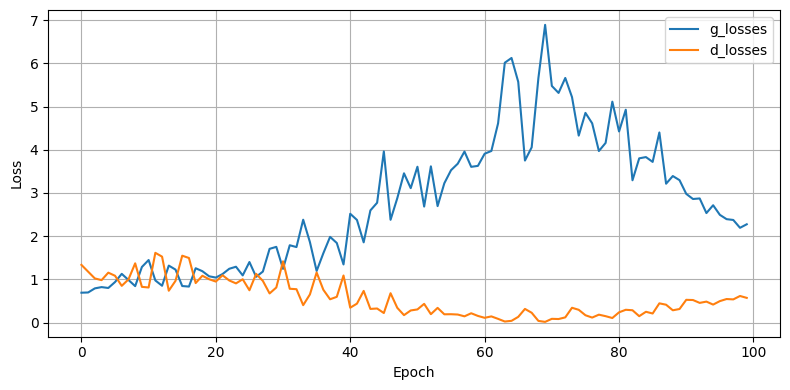

In [22]:
# display losses
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(g_losses, label="g_losses")
ax.plot(d_losses, label="d_losses")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

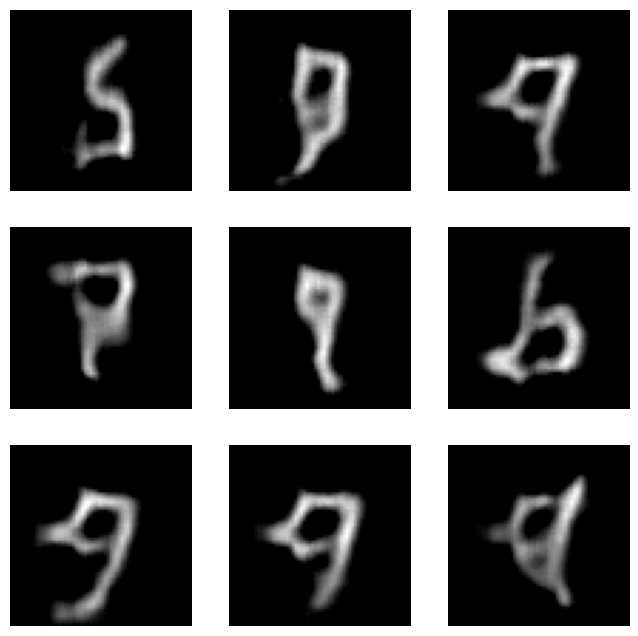

In [24]:
# show generated images
generator.eval()
z = torch.randn(9, z_dim, 1, 1, device=device)
outputs = generator(z).detach()
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(outputs[i].squeeze().cpu().numpy(), cmap="gray")
    ax.set_axis_off()